In [73]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [74]:
def inference(model, x, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        out = model(x)
    return out

In [75]:
def unpack(compressed):
  ''' given a bit encoded voxel grid, make a normal voxel grid out of it.  '''
  uncompressed = np.zeros(compressed.shape[0] * 8, dtype=np.uint8)
  uncompressed[::8] = compressed[:] >> 7 & 1
  uncompressed[1::8] = compressed[:] >> 6 & 1
  uncompressed[2::8] = compressed[:] >> 5 & 1
  uncompressed[3::8] = compressed[:] >> 4 & 1
  uncompressed[4::8] = compressed[:] >> 3 & 1
  uncompressed[5::8] = compressed[:] >> 2 & 1
  uncompressed[6::8] = compressed[:] >> 1 & 1
  uncompressed[7::8] = compressed[:] & 1

  return uncompressed

class KittiLoader(Dataset):
    def __init__(self, root_dir, mode='train', sequences=['00'], split_ratio=1.0, 
                 get_vox_lidar=False, get_vox_invalid=False, get_vox_occluded=False):
        self.root_dir = root_dir
        self.mode = mode
        self.sequences = sequences
        self.image_names = []
        self.image2_dir = {}
        self.image3_dir = {}
        self.voxels_dir = {}
        self.get_vox_lidar=get_vox_lidar
        self.get_vox_invalid=get_vox_invalid
        self.get_vox_occluded=get_vox_occluded
        
        self.scene_size = [51.2, 51.2, 6.4] #unit m, 51.2m = 256 * 0.2m
        self.vox_origin = [0, -25.6, -2]#unit m
        self.voxel_size = 0.2  #m

        for seq in self.sequences:
            self.image2_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_2')
            self.image3_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_3')
            self.voxels_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'voxels')
            seq_image_names = [f.split('.')[0] for f in os.listdir(self.image2_dir[seq]) if f.endswith('.png')]
            self.image_names.extend([(seq, img_name) for img_name in seq_image_names])
        
        split_idx = int(len(self.image_names) * split_ratio )
        
        if self.mode == 'train':
            self.image_names = self.image_names[:split_idx]
        else:
            self.image_names = self.image_names[split_idx:]
        
        # Define transformations for standardization and conversion to tensor
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet mean
                                 std=[0.229, 0.224, 0.225])  # Standard ImageNet std
        ])

        self.raw_class_labels= {
                0: "unlabeled",#
                1: "outlier",
                10: "car",#
                11: "bicycle",#
                13: "bus",
                15: "motorcycle",#
                16: "on-rails",
                18: "truck",#
                20: "other-vehicle",#
                30: "person",#
                31: "bicyclist",#
                32: "motorcyclist",#
                40: "road",#
                44: "parking",#
                48: "sidewalk",#
                49: "other-ground",#
                50: "building",#
                51: "fence",#
                52: "other-structure",
                60: "lane-marking",
                70: "vegetation",#
                71: "trunk",#
                72: "terrain",#
                80: "pole",#
                81: "traffic-sign",#
                99: "other-object",
                252: "moving-car",
                253: "moving-bicyclist",
                254: "moving-person",
                255: "moving-motorcyclist",
                256: "moving-on-rails",
                257: "moving-bus",
                258: "moving-truck",
                259: "moving-other-vehicle"
        }
        self.class_map = {
            0 : 0,     # "unlabeled"
            1 : 0,     # "outlier" mapped to "unlabeled" --------------------------mapped
            10: 1,     # "car"
            11: 2,     # "bicycle"
            13: 5,     # "bus" mapped to "other-vehicle" --------------------------mapped
            15: 3,     # "motorcycle"
            16: 5,     # "on-rails" mapped to "other-vehicle" ---------------------mapped
            18: 4,     # "truck"
            20: 5,     # "other-vehicle"
            30: 6,     # "person"
            31: 7,     # "bicyclist"
            32: 8,     # "motorcyclist"
            40: 9,     # "road"
            44: 10,    # "parking"
            48: 11,    # "sidewalk"
            49: 12,    # "other-ground"
            50: 13,    # "building"
            51: 14,    # "fence"
            52: 15,     # "other-structure" mapped to "unlabeled" ------------------mapped ####
            60: 9,     # "lane-marking" to "road" ---------------------------------mapped
            70: 15,    # "vegetation"
            71: 16,    # "trunk"
            72: 17,    # "terrain"
            80: 18,    # "pole"
            81: 19,    # "traffic-sign"
            99: 15,     # "other-object" to "unlabeled" ----------------------------mapped ####
            252: 1,    # "moving-car" to "car" ------------------------------------mapped
            253: 7,    # "moving-bicyclist" to "bicyclist" ------------------------mapped
            254: 6,    # "moving-person" to "person" ------------------------------mapped
            255: 8,    # "moving-motorcyclist" to "motorcyclist" ------------------mapped
            256: 5,    # "moving-on-rails" mapped to "other-vehicle" --------------mapped
            257: 5,    # "moving-bus" mapped to "other-vehicle" -------------------mapped
            258: 4,    # "moving-truck" to "truck" --------------------------------mapped
            259: 5,    # "moving-other"-vehicle to "other-vehicle" ----------------mapped
        }


        self.class_freqs = np.array(
            [
                5.41773033e09,
                1.57835390e07,
                1.25136000e05,
                1.18809000e05,
                6.46799000e05,
                8.21951000e05,
                2.62978000e05,
                2.83696000e05,
                2.04750000e05,
                6.16887030e07,
                4.50296100e06,
                4.48836500e07,
                2.26992300e06,
                5.68402180e07,
                1.57196520e07,
                1.58442623e08,
                2.06162300e06,
                3.69705220e07,
                1.15198800e06,
                3.34146000e05,
            ]
        )
        self.class_names = [
            "empty",
            "car",
            "bicycle",
            "motorcycle",
            "truck",
            "other-vehicle",
            "person",
            "bicyclist",
            "motorcyclist",
            "road",
            "parking",
            "sidewalk",
            "other-ground",
            "building",
            "fence",
            "vegetation",
            "trunk",
            "terrain",
            "pole",
            "traffic-sign",
        ]

        self.class_weights = torch.from_numpy(
            1 / np.log(self.class_freqs+ 0.001)
        )



    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq, img_name = self.image_names[idx]
        img2_name = os.path.join(self.image2_dir[seq], img_name + '.png')
        img3_name = os.path.join(self.image3_dir[seq], img_name + '.png')
        if self.get_vox_lidar:
            voxel_name = os.path.join(self.voxels_dir[seq], img_name + '.bin')
        label_name = os.path.join(self.voxels_dir[seq], img_name + '.label')
        if self.get_vox_invalid:
            invalid_name = os.path.join(self.voxels_dir[seq], img_name + '.invalid')
        if self.get_vox_occluded:
            occluded_name = os.path.join(self.voxels_dir[seq], img_name + '.occluded')
        
        
        # Load and transform images
        left_image = self.transform(Image.open(img2_name).convert('RGB'))
        right_image = self.transform(Image.open(img3_name).convert('RGB'))

        extra_data = []
        # Load voxel data and convert to tensor
        if self.get_vox_lidar:
            voxel_data = torch.tensor(unpack(np.fromfile(voxel_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_data)
        #  0 invalid 1-19 class and 255 invalid
        voxel_labels = np.fromfile(label_name, dtype=np.uint16).reshape(256, 256, 32).astype(np.float32)
        voxel_labels = torch.tensor(np.vectorize(self.class_map.get)(voxel_labels))
        #print(voxel_data.shape)
        #print(voxel_labels.shape)
        
        if self.get_vox_occluded:
            voxel_occluded = torch.tensor(unpack(np.fromfile(occluded_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_occluded)
        
        if self.get_vox_invalid:
            voxel_invalid = torch.tensor(unpack(np.fromfile(invalid_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_invalid)
        
        
        
        if len(extra_data) != 0:
            return left_image, right_image, voxel_labels, tuple(extra_data)
        else:
            return left_image, right_image, voxel_labels
    
    
    def get_data(self, idx):
        return self.__getitem__(idx)









In [76]:
def voxel_to_coordinates(voxel_data, voxel_size=0.01, threshold = 0):
    # 获取体素数据的形状
    xx, yy, zz = voxel_data.shape

    # 初始化坐标和标签列表
    x_coords = []
    y_coords = []
    z_coords = []
    tags = []

    # 遍历体素数据
    for x in range(xx):
        for y in range(yy):
            for z in range(zz):
                tag = voxel_data[x, y, z]
                # 只记录非零标签的体素
                if tag > threshold:
                    x_coords.append(x * voxel_size)
                    y_coords.append(y * voxel_size)
                    z_coords.append(z * voxel_size)
                    tags.append(tag)

    return np.array(x_coords), np.array(y_coords), np.array(z_coords), np.array(tags)

def visualize_labeled_array3d(voxel_data, num_classes=21, size = None, marker = None):
        voxel_data = voxel_data.astype(np.uint16)
        x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])


        # 创建颜色比例尺
        color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#0f0", "#00f"])

        fig = ipv.figure()

        # 确定tags中的唯一值
        unique_tags = np.unique(tags)

        # 为每个唯一的tag值创建一个scatter
        for tag in unique_tags:
            # 过滤出当前tag的坐标
            mask = tags == tag
            x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
            
            ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(tag),x_filtered.shape[0]))
        ipv.xyzlabel('y','x','z')
        ipv.view(0, -50, distance=2.5)
        ipv.show()

def plot_tensor2d(img_tensor):
    tensor = img_tensor.permute(1, 2, 0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)

def visualize_3D_points_in_jupyter(points_3D, size=2, marker="sphere"):
    # Assuming points_3D is a N x 3 numpy array
    x = points_3D[:, 0]
    y = points_3D[:, 1]
    z = points_3D[:, 2]

    ipv.quickscatter(x, y, z, size=size, marker=marker)
    ipv.show()

In [235]:
sys.path.append("/workspace/HKU-OccNet/")
from utils.calib_utils import *
img_width, img_height = 1241, 376
calib = read_calib("/workspace/HKU-OccNet/calib.txt")
calib_proj = get_projections(img_width, img_height, calib)
train_set = KittiLoader(root_dir="/workspace/Dataset2/dataset", mode='train', 
                        sequences=['00', '01', '02', '03', '04', '05'], 
                        get_vox_lidar=True, get_vox_invalid=True, get_vox_occluded=True)

vox_origin = torch.tensor([0, 128, 10])
vf_mask = calib_proj['fov_mask_1'].view(256, 256, 32)

cull_mask = torch.zeros((256, 256, 32), dtype=torch.float)
cull_mask[:int(0.6 * 256), :, :] = True

def preprocess_gt(voxel_labels, extra_labels, cull_mask, vf_mask):
    voxel_lidar, voxel_occluded, voxel_invalid = extra_labels
    v = voxel_labels.clone()
    v[(v == 0) & (voxel_invalid > 0.5)] = 20
    v[~vf_mask] = 0
    v = v * cull_mask
    return v

In [236]:
int(len(train_set))

11308

In [239]:
left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
# print("left_img.shape:", left_img.shape)
# print("right_img.shape:", right_img.shape)
# print("voxel_labels.shape:", voxel_labels.shape)
# print("voxel_lidar.shape:", voxel_lidar.shape)
# print("voxel_invalid.shape:", voxel_invalid.shape)
# print("voxel_occluded.shape:", voxel_occluded.shape)

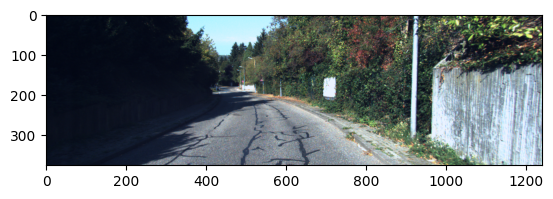

In [240]:
plot_tensor2d(left_img)

In [109]:
#visualize_labeled_array3d(voxel_labels.cpu().numpy(), size = 0.5, marker = 'box')

In [110]:
#visualize_labeled_array3d(voxel_occluded.cpu().numpy(), size = 0.5, marker = 'box')

In [111]:
#visualize_labeled_array3d((voxel_invalid).cpu().numpy(), size = 0.5, marker = 'box')

In [112]:
#voxel_invalid[0][0][0].dtype

In [113]:
# v = torch.logical_or(voxel_occluded.bool(), voxel_invalid.bool()).float()
# visualize_labeled_array3d((1 - v).cpu().numpy(), size = 0.5, marker = 'box')

In [114]:
#torch.unique(voxel_labels)

In [130]:
cull_mask = torch.zeros((256, 256, 32), dtype=torch.float)
cull_mask[:int(0.6 * 256), :, :] = True

v = voxel_labels.clone()
v[(v == 0) & (voxel_invalid > 0.5)] = 20
v[~vf_mask] = 0
v = v * cull_mask

In [131]:
visualize_labeled_array3d((v).cpu().numpy(), size = 0.5, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [224]:
# reference: https://github.com/duyphuongcri/Variational-AutoEncoder/blob/master/model.py

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math 
class Conv3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet3D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p), 
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x) + x
        return out


class ConvUpSample3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
        super(ConvUpSample3D_Block, self).__init__()
        self.up = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size),
            nn.Upsample(scale_factor=scale, mode='trilinear', align_corners=align_corners),
        )
    def forward(self, x):
        return self.up(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = Conv3D_Block(ch_in=1, ch_out=32, k_size=3)
        self.res_block1 = ResNet3D_Block(ch=32, k_size=3)
        self.MaxPool1 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv2 = Conv3D_Block(ch_in=32, ch_out=64, k_size=3)
        self.res_block2 = ResNet3D_Block(ch=64, k_size=3)
        self.MaxPool2 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv3 = Conv3D_Block(ch_in=64, ch_out=128, k_size=3)
        self.res_block3 = ResNet3D_Block(ch=128, k_size=3)
        self.MaxPool3 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv4 = Conv3D_Block(ch_in=128, ch_out=256, k_size=3)
        self.res_block4 = ResNet3D_Block(ch=256, k_size=3)
        self.MaxPool4 = nn.MaxPool3d(3, stride=2, padding=1)

        self.z_mean = nn.Linear(256*16*16*2, latent_dim)
        self.z_log_sigma = nn.Linear(256*16*16*2, latent_dim)
            
        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            stdv = 1.0 / math.sqrt(weight.size(0))
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.res_block1(x1)
        x1 = self.MaxPool1(x1) 
        #print(x1.shape) #[1, 32, 128, 128, 16]
        
        x2 = self.conv2(x1)
        x2 = self.res_block2(x2)
        x2 = self.MaxPool2(x2) 
        #print(x2.shape) #[1, 64, 64, 64, 8]

        x3 = self.conv3(x2)
        x3 = self.res_block3(x3)
        x3 = self.MaxPool3(x3) 
        #print(x3.shape) #[1, 128, 32, 32, 4]
        
        x4 = self.conv4(x3)
        x4 = self.res_block4(x4) 
        x4 = self.MaxPool4(x4) 
        #print(x4.shape) #[1, 256, 16, 16, 2]
        x = x4

        x = torch.flatten(x, start_dim=1)
        
        z_mean = self.z_mean(x)
        z_log_sigma = self.z_log_sigma(x)
        
        
        return z_mean, z_log_sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, device):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.linear_up = nn.Linear(latent_dim, 256*16*16*2)
        self.relu = nn.ReLU()
        
        self.upsample4 = ConvUpSample3D_Block(ch_in=256, ch_out=128, k_size=1, scale=2)
        self.res_block4 = ResNet3D_Block(ch=128, k_size=3)
        
        self.upsample3 = ConvUpSample3D_Block(ch_in=128, ch_out=64, k_size=1, scale=2)
        self.res_block3 = ResNet3D_Block(ch=64, k_size=3)        
        
        self.upsample2 = ConvUpSample3D_Block(ch_in=64, ch_out=32, k_size=1, scale=2)
        self.res_block2 = ResNet3D_Block(ch=32, k_size=3)   
        
        self.upsample1 = ConvUpSample3D_Block(ch_in=32, ch_out=1, k_size=1, scale=2)
        self.res_block1 = ResNet3D_Block(ch=1, k_size=3)   
        
        self.epsilon = torch.normal(size=(1, latent_dim), mean=0, std=1.0, device=device)
        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            stdv = 1.0 / math.sqrt(weight.size(0))
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, z_mean, z_log_sigma):
        z = z_mean + z_log_sigma.exp()*self.epsilon
        
        x4_ = self.linear_up(z)
        x4_ = self.relu(x4_)

        #print(x4_.shape)
        x4_ = x4_.view(-1, 256, 16, 16, 2)
        x4_ = self.upsample4(x4_) 
        x4_ = self.res_block4(x4_)

        x3_ = self.upsample3(x4_) 
        x3_ = self.res_block3(x3_)

        x2_ = self.upsample2(x3_) 
        x2_ = self.res_block2(x2_)

        x1_ = self.upsample1(x2_) 
        x1_ = self.res_block1(x1_)

        return x1_


class VAE3D(nn.Module):
    def __init__(self, latent_dim=128, 
                 device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')):
        super(VAE3D, self).__init__()
        
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, device)

        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            stdv = 1.0 / math.sqrt(weight.size(0))
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        z_mean, z_log_sigma = self.encoder(x)
        y = self.decoder(z_mean, z_log_sigma)
        return y, z_mean, z_log_sigma

    def l1_loss(x, y):
        return F.l1_loss(x, y, reduction='mean')
        
    def guassian_kl_divergence(z_mean, z_log_sigma):
        z_log_var = z_log_sigma * 2
        return 0.5 * torch.mean(z_mean**2 + z_log_var.exp() - z_log_var - 1)

    def step(self, x):
        y, z_mean, z_log_sigma = self(x)
        loss = guassian_kl_divergence(z_mean, z_log_sigma)
        loss += l1_loss(x, y)
        return loss
        

In [225]:
vae3d = VAE3D(latent_dim=128, device='cpu')
from torchsummary import summary
#summary(vae3d.encoder, input_size=(1, 256, 256, 32), device="cpu")

In [226]:
x = torch.rand(1, 1, 256, 256, 32)
y, z_mean, z_log_sigma = vae3d(x)
print(y.shape)
print(z_mean.shape)
print(z_log_sigma.shape)

torch.Size([1, 1, 256, 256, 32])
torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
model = VAE3D(latent_dim=128, device)

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.01)
num_epochs = 10
best_loss = np.inf

model = model.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, voxel_labels, extra_labels) in tqdm(enumerate(train_dataloader),
                                                                     total = len(train_dataloader)):
        loss = model.step(left_img, right_img, voxel_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for (left_img, right_img, voxel_labels) in tqdm(val_dataloader):
            loss = model.step(left_img, right_img, voxel_labels)
            optimizer.zero_grad()
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'bevocc.pth')
        best_loss = (train_loss / len(train_dataloader))